In [1]:
%load_ext jupyter_black

## Load Packages <a class="anchor" id="load_packages"></a>

Packages relavant to th code are loaded below. Additionally, specific options or parameters are also set. For example, display options are set for `pandas` and the environment path to the environment variable file is provided for the `dotenv` package.

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import sys
import pandas as pd
import numpy as np
import requests
from spotify_dl import spotify_dl
from pathlib import Path
import time
import os
from dotenv import load_dotenv  # changed magic command to explicit load
import librosa
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import pairwise
from sklearn.model_selection import train_test_split
from typing import List
from flask import Flask, redirect, request

pd.set_option("display.max_rows", None)  # pandas dataframe formatting options
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format


custom_env_path = "../../brainstation_capstone_cfg.env"  # environment variables file

## Setting Environment Variables <a class="anchor" id="set_env_vars"></a>

In [3]:
# Spotify Developer Credentials
load_dotenv(dotenv_path=custom_env_path)
CLIENT_ID = os.environ.get("SPOTIPY_CLIENT_ID")
# client ID from app
CLIENT_SECRET = os.environ.get("SPOTIPY_CLIENT_SECRET")
# client secret from app
REDIRECT_URI = os.environ.get("REDIRECT_URI")
# redirect URI - the URI used here matches the one used within the app
SCOPE = "{} {}".format(os.environ.get("SCOPE_PUBLIC"), os.environ.get("SCOPE_PRIVATE"))
# formatted the scope this way to allow for custom configurations in the future
USERNAME = os.environ.get("SPOTIFY_USERNAME")
# Spotify username

## Read in Kaggle Data

In [121]:
kaggle_df = pd.read_csv("../data/SpotifyFeatures.csv")

In [122]:
kaggle_df.loc[kaggle_df.track_name.str.lower().str.contains("take on me")]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
3096,Alternative,Weezer,Take On Me,1ZB2qWsheGabSEYvBYxjKn,59,0.01,0.44,223560,0.76,0.00,G#,0.09,-3.86,Major,0.04,167.96,4-Apr,0.74
13631,Dance,a-ha,Take on Me,2WfaOiMkCvy7F5fcp2zZ8L,84,0.02,0.57,225280,0.90,0.00,F#,0.09,-7.64,Minor,0.05,84.41,4-Apr,0.88
17473,Dance,a-ha,Take On Me,6Id7qFA0mNC4VCkQbG1PyZ,0,0.01,0.53,228520,0.93,0.00,F#,0.05,-6.44,Minor,0.05,169.42,4-Apr,0.81
19917,Dance,a-ha,Take On Me - Kygo Remix,5UHuuQGEgMbZrYnHjQG9ny,58,0.16,0.54,226667,0.78,0.00,A,0.14,-6.01,Major,0.11,179.96,4-Apr,0.62
77365,Children’s Music,Weezer,Take On Me,1ZB2qWsheGabSEYvBYxjKn,70,0.01,0.44,223560,0.76,0.00,G#,0.09,-3.86,Major,0.04,167.96,4-Apr,0.74
108853,Pop,a-ha,Take on Me,2WfaOiMkCvy7F5fcp2zZ8L,84,0.02,0.57,225280,0.90,0.00,F#,0.09,-7.64,Minor,0.05,84.41,4-Apr,0.88
110186,Pop,Weezer,Take On Me,1ZB2qWsheGabSEYvBYxjKn,70,0.01,0.44,223560,0.76,0.00,G#,0.09,-3.86,Major,0.04,167.96,4-Apr,0.74
151905,Pop,a-ha,Take On Me - MTV Unplugged,7htt7UuxHL5wneOcMWJP5E,65,0.96,0.47,253907,0.20,0.00,A,0.68,-13.24,Major,0.04,127.36,4-Apr,0.31
155216,Rock,Reel Big Fish,Take On Me,7IfckgnBsIdP4XE4tfWEDN,60,0.02,0.58,199253,0.94,0.00,A,0.13,-3.00,Major,0.12,97.88,4-Apr,0.84
156518,Ska,Reel Big Fish,Take On Me,7IfckgnBsIdP4XE4tfWEDN,60,0.02,0.58,199253,0.94,0.00,A,0.13,-3.00,Major,0.12,97.88,4-Apr,0.84


## Feature Function Definitions

In [6]:
# How was this solved? sampling rate must be explicitly passed to every function
# This includes the display function itself!
# Hence, the sampling rate is now an output from the function itself
def get_mfcc(y, sr):
    mfcc = librosa.power_to_db(librosa.feature.mfcc(y=y, sr=sr), ref=np.max)
    return mfcc


def get_melspectrogram(y, sr):
    melspectrogram = librosa.power_to_db(
        librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max
    )
    # this is a power spectrum (amplitude squared)
    return melspectrogram


def get_chroma_vector(y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return chroma


def get_tonnetz(y, sr):
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    return tonnetz


def get_feature(input_file_path, track_id):
    # Load data
    y, sr = librosa.load(
        input_file_path,
        sr=None,
        offset=10,
        duration=120,
    )
    # Extracting MFCC feature
    mfcc = get_mfcc(y, sr)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))
    np.save(f"../data/vectorized_mp3s/raw/mfcc_{track_id}.npy", mfcc_feature)

    # Extracting Mel Spectrogram feature
    melspectrogram = get_melspectrogram(y, sr)
    melspectrogram_mean = melspectrogram.mean(axis=1)
    melspectrogram_min = melspectrogram.min(axis=1)
    melspectrogram_max = melspectrogram.max(axis=1)
    melspectrogram_feature = np.concatenate(
        (melspectrogram_mean, melspectrogram_min, melspectrogram_max)
    )
    np.save(
        f"../data/vectorized_mp3s/raw/melspectrogram_{track_id}.npy",
        melspectrogram_feature,
    )

    # Extracting chroma vector feature
    chroma = get_chroma_vector(y, sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))
    np.save(f"../data/vectorized_mp3s/raw/chroma_{track_id}.npy", chroma_feature)

    # Extracting tonnetz feature
    tntz = get_tonnetz(y, sr)
    tntz_mean = tntz.mean(axis=1)
    tntz_min = tntz.min(axis=1)
    tntz_max = tntz.max(axis=1)
    tntz_feature = np.concatenate((tntz_mean, tntz_min, tntz_max))
    np.save(f"../data/vectorized_mp3s/raw/tonnetz_{track_id}.npy", tntz_feature)
    # return chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature
    feature = np.concatenate(
        (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature)
    )
    return feature


# May not have use of this function yet....need to fix pairwise comparison
# Save spectra one stage before as separate vectors BEFORE concatenation
def create_spectra(spec_data, sr, type, track_id):
    if type == "mfcc":
        plt.figure()
        librosa.display.specshow(mel_data, y_axis="mel", x_axis="time", sr=sr)
        plt.title("Mel Frequency Cepstral Coefficients")
        plt.colorbar(format="%+2.0f dB")
        plt.savefig(f"../data/mp3_spectra/{track_id}.png", bbox_inches="tight")
    if type == "melspectrogram":
        plt.figure()
        librosa.display.specshow(mel_data, y_axis="mel", x_axis="time", sr=sr)
        plt.title("Melspectrogram")
        plt.colorbar(format="%+2.0f dB")
        plt.savefig(f"../data/mp3_spectra/{track_id}.png", bbox_inches="tight")
    if type == "chroma":
        plt.figure()
        librosa.display.specshow(
            mel_data, y_axis="chroma", x_axis="time", sr=sr, vmin=0, vmax=1
        )
        plt.title("Chroma STFT")
        plt.colorbar(format="%+2.0f dB")
        plt.savefig(f"../data/mp3_spectra/{track_id}.png", bbox_inches="tight")
    if type == "tonnetz":
        plt.figure()
        librosa.display.specshow(
            mel_data, y_axis="tonnetz", x_axis="time", sr=sr, vmin=0, vmax=1
        )
        plt.title("Tonnetz")
        plt.colorbar(format="%+2.0f dB")
        plt.savefig(f"../data/mp3_spectra/{track_id}.png", bbox_inches="tight")
        # Will have to get the track_id to save the file
        # Not sure if the spectra must have the axis labels or the title

In [7]:
# test_file = "/Users/vii/repos/brainstation_capstone/data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3"
# track_id = "1ZB2qWsheGabSEYvBYxjKn"
# chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature = get_feature(
#     test_file, track_id
# )

In [8]:
# chroma_feature

In [9]:
# chroma_feature.shape

In [10]:
# chroma_npy = np.load("../data/vectorized_mp3s/chroma_1ZB2qWsheGabSEYvBYxjKn.npy")
# chroma_npy

In [11]:
# x = np.array([1, 2])

In [12]:
# np.array_equal(
#     chroma_feature, chroma_npy
# )  # test if the two arrays are the same after saving and loading

In [13]:
# np.array_equal(chroma_npy, x)  # sanity check

## Vectorize Data - Pairwise Cosine Similarity

In [14]:
data_dir = Path("../data/mp3s/")
output_dir = Path("../data/vectorized_mp3s/pairwise_parquets/")
path_glob = data_dir.rglob("*.mp3")
file_paths = []
for file_path in path_glob:
    file_paths.append(file_path)  # creates a list for repeated iteration
    # if this is not done, the .rglob command above has to be repeated to regenerate iterator
len(file_paths)  # number of mp3s in directory

11578

The code below runs, but has been commented out to make this notebook faster. A screenshot is provided below:
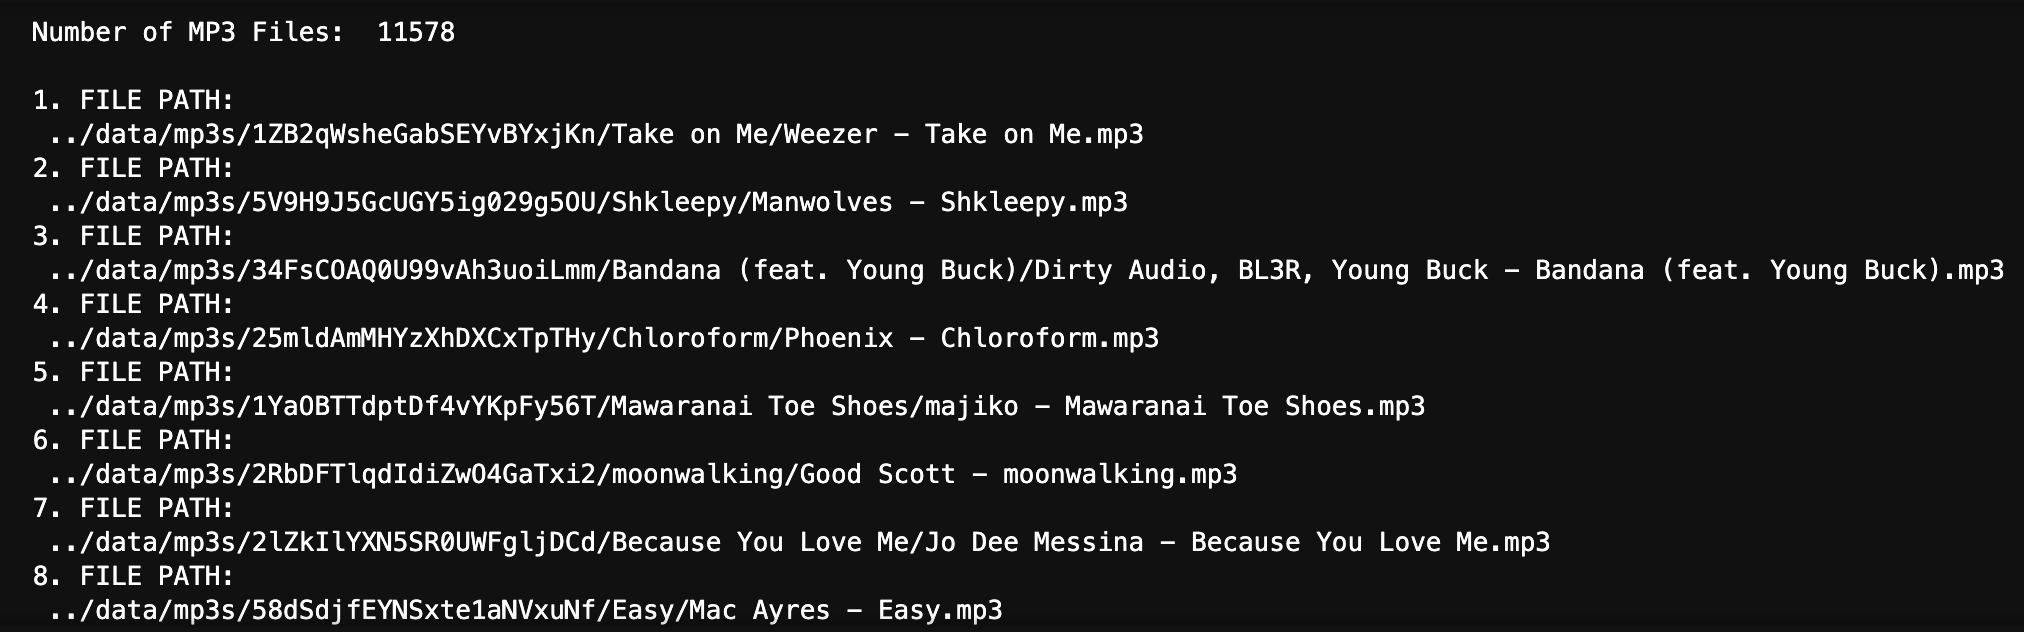

In [13]:
# data_dir = Path("../data/mp3s/")
# output_dir = Path("../data/vectorized_mp3s/pairwise_parquets/")
# downloaded_path_glob = data_dir.rglob("*.mp3")
# output_path_glob = output_dir.rglob("*.parquet")
# count = 1
# file_paths = [file_path for file_path in downloaded_path_glob]
# print("Number of MP3 Files: ", len(file_paths), "\n")
# vectorized_track_ids = [file_path.stem for file_path in output_path_glob]
# for file_path in file_paths:
#     print(f"{count}. FILE PATH: \n", f"{file_path}")
#     path_split = str(file_path).split("/")
#     track_id = path_split[3]
#     if (len(vectorized_track_ids) > 0) & (track_id in vectorized_track_ids):
#         print(f"{track_id} has already been vectorized...skipping...")
#         count += 1
#     else:
#         track = get_feature(file_path, track_id)
#         vectorized_df = pd.DataFrame(track).T
#         vectorized_df["track_id"] = track_id
#         vectorized_df = vectorized_df.set_index(vectorized_df.track_id).drop(
#             columns="track_id"
#         )
#         vectorized_df.columns = vectorized_df.columns.astype(str)
#         vectorized_df.to_parquet(
#             f"../data/vectorized_mp3s/pairwise_parquets/{track_id}.parquet"
#         )
#         count += 1

Number of MP3 Files:  11578 

1. FILE PATH: 
 ../data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3
2. FILE PATH: 
 ../data/mp3s/5V9H9J5GcUGY5ig029g5OU/Shkleepy/Manwolves - Shkleepy.mp3
3. FILE PATH: 
 ../data/mp3s/34FsCOAQ0U99vAh3uoiLmm/Bandana (feat. Young Buck)/Dirty Audio, BL3R, Young Buck - Bandana (feat. Young Buck).mp3
4. FILE PATH: 
 ../data/mp3s/25mldAmMHYzXhDXCxTpTHy/Chloroform/Phoenix - Chloroform.mp3
5. FILE PATH: 
 ../data/mp3s/1YaOBTTdptDf4vYKpFy56T/Mawaranai Toe Shoes/majiko - Mawaranai Toe Shoes.mp3
6. FILE PATH: 
 ../data/mp3s/2RbDFTlqdIdiZwO4GaTxi2/moonwalking/Good Scott - moonwalking.mp3
7. FILE PATH: 
 ../data/mp3s/2lZkIlYXN5SR0UWFgljDCd/Because You Love Me/Jo Dee Messina - Because You Love Me.mp3
8. FILE PATH: 
 ../data/mp3s/58dSdjfEYNSxte1aNVxuNf/Easy/Mac Ayres - Easy.mp3
9. FILE PATH: 
 ../data/mp3s/6wulmNhwuptjQkNzWHZ7Ym/Don Palabras/Maldita Vecindad Y Los Hijos Del 5to. Patio - Don Palabras.mp3
10. FILE PATH: 
 ../data/mp3s/6vLNSXMZ08nlGMgcQ17c

858. FILE PATH: 
 ../data/mp3s/7BDGjDqOuUbZkwDPSXoMl0/Saturday Night/The Cat Empire - Saturday Night.mp3
859. FILE PATH: 
 ../data/mp3s/6R40BJoXMj9R942vnhuFsS/Kenner Boogie/Jon Batiste - Kenner Boogie.mp3
860. FILE PATH: 
 ../data/mp3s/0FeqPtdkwXs54spLxfWnqr/Smoke Ring Halo/The Wood Brothers - Smoke Ring Halo.mp3
861. FILE PATH: 
 ../data/mp3s/6VMT3SzIMbNoR5lsUsniQY/Stars/Skillet - Stars.mp3
862. FILE PATH: 
 ../data/mp3s/4kxpoNJE8r3LgsSzEqaEDU/Bluebeard/Cocteau Twins - Bluebeard.mp3
863. FILE PATH: 
 ../data/mp3s/5vImHuu5YuSorWonbi81Hs/Misfit/Naji - Misfit.mp3
864. FILE PATH: 
 ../data/mp3s/1BZdJrCYel0jMNmKY8KkUD/KeeP IN tOUcH (feat. Bryson Tiller)/Tory Lanez, Bryson Tiller - KeeP IN tOUcH (feat. Bryson Tiller).mp3
865. FILE PATH: 
 ../data/mp3s/17TXMth2jOMKu0hKHnQBLy/Where Did I Put That Thing  Bibbidi-Bobbidi-Boo (The Magic Song) - From Cinderella  Soundtrack Version/Verna Felton - #Where Did I Put That Thing # Bibbidi-Bobbidi-Boo (The Magic Song) - From ##Cinderella## # Soundtrack 

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1394. FILE PATH: 
 ../data/mp3s/3mskluxUoD4xICumdJCR7l/Dave McGillivray/Jeff Beal - Dave McGillivray.mp3
1395. FILE PATH: 
 ../data/mp3s/0XVQTr58DZbLUcjacnTp8k/Madness/Ruelle - Madness.mp3
1396. FILE PATH: 
 ../data/mp3s/18765csbulflFn1Ww4bcys/Change/Clay Walker - Change.mp3
1397. FILE PATH: 
 ../data/mp3s/7Kth3JPrAA9t1gwDL61zSn/Lotta Love/Jack & Jack - Lotta Love.mp3
1398. FILE PATH: 
 ../data/mp3s/5ltBz3a5wh9IWwdhBaHu4j/The Hard Stuff/Justin Timberlake - The Hard Stuff.mp3
1399. FILE PATH: 
 ../data/mp3s/6g76Hz2BlK8Up1lpO2ZfA1/On the Tank/John Williams - On the Tank.mp3
1400. FILE PATH: 
 ../data/mp3s/4nrWU5PRlFJubLjahofpOU/Gravity/Papa Roach - Gravity.mp3
1401. FILE PATH: 
 ../data/mp3s/4d51ROVbamfPFmSeSMPnS8/People Change/for KING & COUNTRY - People Change.mp3
1402. FILE PATH: 
 ../data/mp3s/4Ahphc0UzRSoMpJRHgnGQK/I Want to Live/Skillet - I Want to Live.mp3
1403. FILE PATH: 
 ../data/mp3s/1R4hG0ZP1PBrP14eeOhdB5/Destroyer/Dead Man Winter - Destroyer.mp3
1404. FILE PATH: 
 ../data/mp

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


2682. FILE PATH: 
 ../data/mp3s/2cgZfcnb639TaZhd1AU8iz/Bun Up the Dance/Dillon Francis, Skrillex - Bun Up the Dance.mp3
2683. FILE PATH: 
 ../data/mp3s/6l4qV9VNeCOesvcLPJMO9y/ - .mp3
2684. FILE PATH: 
 ../data/mp3s/3DusC19xQoOt98IVXnH9uS/Corporate Cafeteria (Acoustic)/The Expendables - Corporate Cafeteria (Acoustic).mp3
2685. FILE PATH: 
 ../data/mp3s/0l0CvurVUrr2w3Jj1hOVFc/NO/Meghan Trainor - NO.mp3
2686. FILE PATH: 
 ../data/mp3s/6TFGNgCyhgHKNn046iG6fa/Victorious/Wolfmother - Victorious.mp3
2687. FILE PATH: 
 ../data/mp3s/28POcTYQKfkjz6qTIvtjG1/On Call/Kings of Leon - On Call.mp3
2688. FILE PATH: 
 ../data/mp3s/2zXfpzLG8YDA6JX3RJ0gEF/Atoll/Nai Palm - Atoll.mp3
2689. FILE PATH: 
 ../data/mp3s/2OtppI9PZe4h77OZGmecvm/Second Chance/Rend Collective - Second Chance.mp3
2690. FILE PATH: 
 ../data/mp3s/0p3sSUXDohjddeKlnvGbCD/Lonely Star/The Weeknd - Lonely Star.mp3
2691. FILE PATH: 
 ../data/mp3s/6TM4kmmFOXAMDdGE3oTYYt/ほんの少し(ALL TIME BEST ver.)/UVERworld - ほんの少し(ALL TIME BEST ver.).mp3
2692.

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


4932. FILE PATH: 
 ../data/mp3s/3RDcUlLGp3SLp2AmUbUbls/Cookie Jar (feat. The-Dream)/Gym Class Heroes, The-Dream - Cookie Jar (feat. The-Dream).mp3
4933. FILE PATH: 
 ../data/mp3s/0lb0z6jpnOO5qYVayvqWoh/Past Life Melodies/The American Boychoir - Past Life Melodies.mp3
4934. FILE PATH: 
 ../data/mp3s/0rU4dLUSToe7uQUfaFCoda/3 Romances sans paroles, Op. 17 No. 3, Andante moderato in A-Flat Major/Gabriel Fauré, Christine Croshaw - 3 Romances sans paroles, Op. 17# No. 3, Andante moderato in A-Flat Major.mp3
4935. FILE PATH: 
 ../data/mp3s/6laONlj9zCF3hPNsQUePM6/アンサー/BUMP OF CHICKEN - アンサー.mp3
4936. FILE PATH: 
 ../data/mp3s/5MxLy1RM6bGy1TK1eba4Ts/Dizzy/MISSIO - Dizzy.mp3
4937. FILE PATH: 
 ../data/mp3s/3Zw4oBI28zPc1pAQJ5RgJV/Risin High/Ancient Astronauts, Raashan Ahmad - Risin High.mp3
4938. FILE PATH: 
 ../data/mp3s/5oDM9YSQIlhuWa0awHF4Z2/I'd Rather/Luther Vandross - I'd Rather.mp3
4939. FILE PATH: 
 ../data/mp3s/2uXidnW2mwi9kk4ZWVr0n5/Satoshi Nakamoto/Gramatik, Adrian Lau, ProbCause - Sato

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


6683. FILE PATH: 
 ../data/mp3s/0xMd5bcWTbyXS7wPrBtZA6/Burn/Ellie Goulding - Burn.mp3
6684. FILE PATH: 
 ../data/mp3s/3blJWKRuT9BPPSi1xN8hHX/Mi Bloncito/Ñejo - Mi Bloncito.mp3
6685. FILE PATH: 
 ../data/mp3s/1eGAZX0TKa5qCxWsvhf8Th/Brick Wall Views/The Lawrence Arms - Brick Wall Views.mp3
6686. FILE PATH: 
 ../data/mp3s/7CTTTbnqMg0ASqjH8v2D9l/Things You Don't Wanna Hear/George Carlin - Things You Don't Wanna Hear.mp3
6687. FILE PATH: 
 ../data/mp3s/7025POEXvQLugcpy6cNVSq/Si Tu Quiere (feat. Pusho)/Yampi, Ozuna, Anuel AA, Pusho - Si Tu Quiere (feat. Pusho).mp3
6688. FILE PATH: 
 ../data/mp3s/3b71h4RqnMZ4d7UmTOwA0m/Constellation/Win and Woo - Constellation.mp3
6689. FILE PATH: 
 ../data/mp3s/334xEybuC25WjWcf93dzPH/Aapan Khoriya Bahaar Pha/Chorus - Aapan Khoriya Bahaar Pha.mp3
6690. FILE PATH: 
 ../data/mp3s/6JXPYFNQKDD9PipDrzxRnP/Eldorado 1997/Manu Chao - Eldorado 1997.mp3
6691. FILE PATH: 
 ../data/mp3s/4dXcDVX3HVQrHFyGE11wue/Last Chance/Anoushka Shankar - Last Chance.mp3
6692. FILE PATH

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


6975. FILE PATH: 
 ../data/mp3s/6uv0GnArZDs61ivyZQL7kS/Then (Piano Mix)/Brad Paisley - Then (Piano Mix).mp3
6976. FILE PATH: 
 ../data/mp3s/3stWWPN41byqp8loPdy92u/Master of None/Beach House - Master of None.mp3
6977. FILE PATH: 
 ../data/mp3s/0dd2y9eFu1qkAnATCRW0G3/I Gave It All/Aquilo - I Gave It All.mp3
6978. FILE PATH: 
 ../data/mp3s/03KisebN9LuPAchPJm32M8/Feeling You/Harrison Storm - Feeling You.mp3
6979. FILE PATH: 
 ../data/mp3s/2DbCvK0YXyy6o1KLeDDDGr/Goodbye Spot - From The Good Dinosaur Score/Mychael Danna, Jeff Danna - #Goodbye Spot - From ##The Good Dinosaur## Score#.mp3
6980. FILE PATH: 
 ../data/mp3s/3TQxkQsyJS03EUwl02Qaub/Soulfight/The Revivalists - Soulfight.mp3
6981. FILE PATH: 
 ../data/mp3s/0g37m5ch9d9r9sL67qLEZ4/Lonely Night/Tribal Seeds - Lonely Night.mp3
6982. FILE PATH: 
 ../data/mp3s/5yNw7KhDPNO8g3Wfm7Eamj/Goodbye Agony/Black Veil Brides - Goodbye Agony.mp3
6983. FILE PATH: 
 ../data/mp3s/1hRDHWWealh2Pk3fnpIe75/Love Rollercoaster/Ohio Players - Love Rollercoaster.

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


7816. FILE PATH: 
 ../data/mp3s/6QUngYwZ65et2ye7Bj85EK/Can You Get To That/Funkadelic - Can You Get To That.mp3
7817. FILE PATH: 
 ../data/mp3s/6lKRMylSZMtA7EqPl0pcdI/Are You Satisfied/MARINA - Are You Satisfied#.mp3
7818. FILE PATH: 
 ../data/mp3s/3xnbJVx4QqsOYip8Cn6OrN/Crunch Time/Chris Travis - Crunch Time.mp3
7819. FILE PATH: 
 ../data/mp3s/62fX8EW16l8St2yL8rMer9/In My Room - Remastered/The Beach Boys - In My Room - Remastered.mp3
7820. FILE PATH: 
 ../data/mp3s/6VzV6RI7641o57TuqfGRpj/Psycho/System Of A Down - Psycho.mp3
7821. FILE PATH: 
 ../data/mp3s/4C7qUVukSszLhhe4gkoUhU/Lovers (Mei and Jin)/Shigeru Umebayashi - Lovers (Mei and Jin).mp3
7822. FILE PATH: 
 ../data/mp3s/423eOE5aQh90ZEBVsg8sDc/Asteroid/Passafire - Asteroid.mp3
7823. FILE PATH: 
 ../data/mp3s/2V8lmCwbEEfEKQ8qf8WaLp/I Think I Love You/Hans Zimmer - I Think I Love You.mp3
7824. FILE PATH: 
 ../data/mp3s/4y5tKWeAUcaFE6O8Fa8XsY/Bali/88GLAM, NAV - Bali.mp3
7825. FILE PATH: 
 ../data/mp3s/0I3r1Xn1OTGWyQWNKYKH7d/Puccini T

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


7926. FILE PATH: 
 ../data/mp3s/4kpbrWUW7rznN3mzjCjQUz/Satellite/The Kills - Satellite.mp3
7927. FILE PATH: 
 ../data/mp3s/04G8U1rkNbiiLNsWo2doW2/Monsoon/Amber Mark, Mia Mark - Monsoon.mp3
7928. FILE PATH: 
 ../data/mp3s/3GPD6qjLLDrhb7mUYCV9wT/City Lights/Motionless In White - City Lights.mp3
7929. FILE PATH: 
 ../data/mp3s/5n51PH1jc6MtLsv8oTorck/Ponmela Aplaudi/Mark B., Don Miguelo - Ponmela Aplaudi.mp3
7930. FILE PATH: 
 ../data/mp3s/6PlntaWbdsWlmHyAkYOZ7L/Year Pin/Tommy Johnagin - Year Pin.mp3
7931. FILE PATH: 
 ../data/mp3s/73guNXAOFu7XB6Sby4ahCp/Majorette/Beach House - Majorette.mp3
7932. FILE PATH: 
 ../data/mp3s/1D70EbZoedMGzZWYZvfQIY/Ride Wit Me/Nelly, City Spud - Ride Wit Me.mp3
7933. FILE PATH: 
 ../data/mp3s/6s4W24i4Ohhmoi0icErJyV/All I Can Do/Bad Royale, Silver - All I Can Do.mp3
7934. FILE PATH: 
 ../data/mp3s/5rHoZOh481VFV9kJovM9RI/Fader/The Temper Trap - Fader.mp3
7935. FILE PATH: 
 ../data/mp3s/0sygO45O9Gq8HGJ5ED1UDz/When She Stops Askin'/Johnnie Taylor - When She Stops

8157. FILE PATH: 
 ../data/mp3s/1tGKjMflcFTEY2IOzKhwLe/Prove It/Crowder, KB - Prove It.mp3
8158. FILE PATH: 
 ../data/mp3s/1uigwk5hNV84zRd5YQQRTk/Pocketful of Sunshine/Natasha Bedingfield - Pocketful of Sunshine.mp3
8159. FILE PATH: 
 ../data/mp3s/5CKHhg31HcYYhwUeeGqvhq/I Wish I Knew How It Would Feel to Be Free/Nina Simone - I Wish I Knew How It Would Feel to Be Free.mp3
8160. FILE PATH: 
 ../data/mp3s/1FAPtCHEPQ4PAx0idWEplO/El Tiempo/#Secreto ##El Famoso Biberon### - El Tiempo.mp3
8161. FILE PATH: 
 ../data/mp3s/1w29UTa5uUvIri2tWtZ12Y/Hip Hop Hooray/Naughty By Nature - Hip Hop Hooray.mp3
8162. FILE PATH: 
 ../data/mp3s/3PPHPKtda5AWLnknzBXu67/Hablan/Dread Mar I - Hablan.mp3
8163. FILE PATH: 
 ../data/mp3s/3XnWIKOGeakpZfc5m9I9bm/Mon amour, ma chérie/Amadou & Mariam - Mon amour, ma chérie.mp3
8164. FILE PATH: 
 ../data/mp3s/65POe3qIlqf2lzeUlNz0s0/Face to Face/Sammie - Face to Face.mp3
8165. FILE PATH: 
 ../data/mp3s/3dlA4fMFba4xbL3vMCapmx/Tell Me A Story/All-Star Kids Cast - Tell Me A S

9225. FILE PATH: 
 ../data/mp3s/1rOlTL4pKQ9Y1fURua4AJR/My Body Is a Cage/Arcade Fire - My Body Is a Cage.mp3
9226. FILE PATH: 
 ../data/mp3s/29chnYiDB5P03F0d5MKKt0/Fight Music/SEKAI NO OWARI - Fight Music.mp3
9227. FILE PATH: 
 ../data/mp3s/414J8tKHbtF16XOiHGBEso/Tezeta (Nostalgia)/Mulatu Astatke - Tezeta (Nostalgia).mp3
9228. FILE PATH: 
 ../data/mp3s/6EeUPx4P1utUI51LTON841/Barry Moves/Allan Rayman - Barry Moves.mp3
9229. FILE PATH: 
 ../data/mp3s/3VptEKa0E1ax6zSzU8xOV8/Música consciente/Zona Ganjah - Música consciente.mp3
9230. FILE PATH: 
 ../data/mp3s/3xVCQGla5LLhrwqNS2FcHo/火炎/QUEEN BEE - 火炎.mp3
9231. FILE PATH: 
 ../data/mp3s/1SI4RkWbR3CbqQjba0ePmO/Everything/G Herbo, Lil Uzi Vert - Everything.mp3
9232. FILE PATH: 
 ../data/mp3s/61gxd3OlpyLftQRvOHyul3/Freeze Up - 2007 Remaster/Operation Ivy - Freeze Up - 2007 Remaster.mp3
9233. FILE PATH: 
 ../data/mp3s/5dJC7LBdtrRjGZW9rAV9vs/Get Off/Chris Brown - Get Off.mp3
9234. FILE PATH: 
 ../data/mp3s/5Zytw4cYysxNiGw41wMmTY/I Must Have That 

9317. FILE PATH: 
 ../data/mp3s/2UrILPsnAc5Jh4VLGyFoKx/Symphony No. 4 in E Minor, Op. 98 IV. Allegro energico e passionato - Più allegro/Johannes Brahms, Wiener Philharmoniker, Carlos Kleiber - Symphony No. 4 in E Minor, Op. 98# IV. Allegro energico e passionato - Più allegro.mp3
9318. FILE PATH: 
 ../data/mp3s/1bXgMtdwYuFAPApWxGbS17/How Great Is Your Love/Phil Wickham - How Great Is Your Love.mp3
9319. FILE PATH: 
 ../data/mp3s/2pJZ1v8HezrAoZ0Fhzby92/What Do I Know/Ed Sheeran - What Do I Know#.mp3
9320. FILE PATH: 
 ../data/mp3s/1TbMm6bsMQHEyhfKoablQD/La Danza/Gioachino Rossini, Juan Diego Flórez, Avi Avital, Filarmonica Gioachino Rossini, Carlo Tenan - La Danza.mp3
9321. FILE PATH: 
 ../data/mp3s/3ycOSYIq21oEvlVLP5uCWT/Hush Money/NITTI - Hush Money.mp3
9322. FILE PATH: 
 ../data/mp3s/2v63nsrBRoEkFZGKaTXA2q/Bang Your Line (feat. Ty Dolla ign)/ELHAE, Ty Dolla #ign - Bang Your Line (feat. Ty Dolla #ign).mp3
9323. FILE PATH: 
 ../data/mp3s/757PJjXAgywxrYkdhMkEV9/Holding on for Life/Broke

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


10165. FILE PATH: 
 ../data/mp3s/2a7z0RvsjwSMWEPwIWO5z2/La Ultima Vez/Feid - La Ultima Vez.mp3
10166. FILE PATH: 
 ../data/mp3s/7os1J5P6JqIxKSxq71QuQC/Hero (feat. Christina Perri) - Deep Mix/Cash Cash, Christina Perri - Hero (feat. Christina Perri) - Deep Mix.mp3
10167. FILE PATH: 
 ../data/mp3s/4qZwVr553XcQNdeqjueeE3/Roses Are Red - Original Version/Aqua - Roses Are Red - Original Version.mp3
10168. FILE PATH: 
 ../data/mp3s/48DPyFzSUNGAYzXM9Zj4Jd/La rondine Chi il bel sogno di Doretta/Giacomo Puccini, Luba Orgonasova, Symfonický orchester Slovenského rozhlasu, Will Humburg - La rondine# Chi il bel sogno di Doretta.mp3
10169. FILE PATH: 
 ../data/mp3s/4xLRNLT9MkHFNpbxuvHmMC/Divertimento No. 10 in F Major, K. 247 III. Menuetto - Trio/Wolfgang Amadeus Mozart, Camerata Salzburg, Sándor Végh - Divertimento No. 10 in F Major, K. 247# III. Menuetto - Trio.mp3
10170. FILE PATH: 
 ../data/mp3s/7pUqeYHnZI8RdhGS2BkAN5/Steel On Steel/Johan Söderqvist, Patrik Andrén - Steel On Steel.mp3
10171. FI

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


10205. FILE PATH: 
 ../data/mp3s/3rMyMv8EjKXoPnaRo2hdJN/Stuntin' Like My Daddy - Street/Birdman, Lil Wayne - Stuntin' Like My Daddy - Street.mp3
10206. FILE PATH: 
 ../data/mp3s/3UUx0JWEJCbKZvhzpruLfe/Letting You Go/Sara Evans - Letting You Go.mp3
10207. FILE PATH: 
 ../data/mp3s/3As1HTUDBTiTDbwnuICy4C/Fisherman's Horizon Piano Collections Version (From Final Fantasy VIII) [For Piano Solo]/Nobuo Uematsu, daigoro789 - #Fisherman's Horizon# Piano Collections Version (From ##Final Fantasy VIII##) [For Piano Solo]#.mp3
10208. FILE PATH: 
 ../data/mp3s/0VSqZ3KStsjcfERGdcWpFO/Les bisous des bisounours/Le Club des Juniors - Les bisous des bisounours.mp3
10209. FILE PATH: 
 ../data/mp3s/7d1ZzOIyACB64aEibmWfH7/Release and Be Free/Kelley Hunt - Release and Be Free.mp3
10210. FILE PATH: 
 ../data/mp3s/4Zhnwb8jvP09aIRAzQMG08/Hospital Beds/Cold War Kids - Hospital Beds.mp3
10211. FILE PATH: 
 ../data/mp3s/2jx8PSP6ncYxZSKqVIoAYa/Cello Concerto in A minor, op. 129 I. Allegro - Nicht zu Schnell/Robert

/Users/vii/anaconda3/envs/brainstation_capstone/lib/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=818
  warnings.warn(


11450. FILE PATH: 
 ../data/mp3s/6QPCo7i6vBXzbdg4muyOdG/Bye Bye Blackbird/Riders In The Sky - Bye Bye Blackbird.mp3
11451. FILE PATH: 
 ../data/mp3s/2v4kQsvlTPEYOIyJkytzGH/In A Sweater Poorly Knit/mewithoutYou - In A Sweater Poorly Knit.mp3
11452. FILE PATH: 
 ../data/mp3s/1eupQ3yeBQPmAUcHyhrXkb/Mal ô mains/Sanseverino - Mal ô mains.mp3
11453. FILE PATH: 
 ../data/mp3s/6FlgXdr8JJLfQvMoHQjE0r/Hey, Snow White/Destroyer - Hey, Snow White.mp3
11454. FILE PATH: 
 ../data/mp3s/7JVlshKyXmnTVJb2H1ybFf/シューティングスター/Hachioji P, Kagamine Rin, Kagamine Len - シューティングスター.mp3
11455. FILE PATH: 
 ../data/mp3s/5JPgWqbVPYZT2k2Gjznl7N/Tyrant (feat. Daniel Caesar) - Remix/Kali Uchis, Daniel Caesar - Tyrant (feat. Daniel Caesar) - Remix.mp3
11456. FILE PATH: 
 ../data/mp3s/4khRdk0vpLBWzGu41Fd7Rl/Quisiera Alejarme (feat. Ozuna & CNCO) - Remix/Wisin, Ozuna, CNCO - Quisiera Alejarme (feat. Ozuna & CNCO) - Remix.mp3
11457. FILE PATH: 
 ../data/mp3s/5yej7ZOcsmAgfOlBsov1ED/I'll Meet You There/Phil Vassar - I'll Me

In [16]:
vectorized_data_path = Path("../data/vectorized_mp3s/pairwise_parquets/")
path_glob = vectorized_data_path.rglob("*.parquet")
dataframes = []
for file_path in path_glob:
    tmp = pd.read_parquet(f"{file_path}")
    dataframes.append(tmp)
vectorized_df = pd.concat(dataframes)

In [17]:
output_file_date = datetime.now().strftime(
    "%Y%m%d"
)  # time stamps the file with the reverse of the date
vectorized_df.to_parquet(f"../data/vectorized_mp3s/pairwise_complete_parquets/{output_file_date}_complete_vectorized_data_pairwise.parquet")

## Pairwise Comparison

In [17]:
vectorized_df = pd.read_parquet(
    "../data/vectorized_mp3s/pairwise_complete_parquets/20230830_complete_vectorized_data_pairwise.parquet"
)

In [18]:
vectorized_df.shape

(11578, 498)

In [19]:
vectorized_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6DQzmTJnaZw4A9IynCGfrM,0.45,0.43,0.53,0.59,0.45,0.39,0.38,0.47,0.44,0.44,0.58,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-28.97,-21.39,-19.32,-21.35,-21.52,-23.20,-24.18,-25.29,-24.75,-24.15,-26.99,-28.73,-28.78,-28.23,-28.24,-30.09,-29.61,-30.58,-26.84,-24.89,-29.86,-28.54,-27.32,-27.29,-25.98,-27.82,-30.40,-29.79,-25.38,-24.87,-28.49,-30.99,-30.36,-30.11,-31.66,-29.57,-27.99,-28.58,-29.65,-32.25,-33.27,-33.26,-33.70,-34.06,-31.10,-30.54,-32.73,-33.27,-34.23,-32.24,-30.73,-32.44,-34.01,-33.14,-31.98,-32.19,-33.11,-31.72,-32.34,-32.06,-32.95,-32.62,-32.68,-34.33,-35.31,-34.26,-32.22,-31.75,-31.97,-32.38,-32.99,-33.86,-34.42,-35.06,-35.78,-37.03,-38.01,-39.42,-39.76,-40.70,-42.31,-43.04,-43.79,-44.97,-45.38,-45.93,-47.02,-46.45,-47.74,-47.35,-46.46,-48.03,-48.48,-48.32,-48.57,-47.87,-47.85,-47.43,-47.78,-46.98,-47.66,-46.50,-47.15,-47.19,-48.13,-47.70,-48.31,-49.65,-50.81,-51.34,-52.03,-52.89,-53.35,-53.39,-54.55,-58.25,-69.53,-72.05,-72.60,-73.24,-73.96,-78.22,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,-80.00,

### Create the pairwise array and sort

In [20]:
pairwise_similarity = pairwise.cosine_similarity(vectorized_df, dense_output=True)
pairwise_similarity

array([[1.        , 0.97973231, 0.99154322, ..., 0.98798471, 0.9864652 ,
        0.96577147],
       [0.97973231, 1.        , 0.98947364, ..., 0.98547464, 0.99003342,
        0.98766516],
       [0.99154322, 0.98947364, 1.        , ..., 0.99357991, 0.99600081,
        0.98262735],
       ...,
       [0.98798471, 0.98547464, 0.99357991, ..., 1.        , 0.99601647,
        0.98547392],
       [0.9864652 , 0.99003342, 0.99600081, ..., 0.99601647, 1.        ,
        0.9892527 ],
       [0.96577147, 0.98766516, 0.98262735, ..., 0.98547392, 0.9892527 ,
        1.        ]])

In [21]:
# sorts the pairwise array so that similar tracks appear closer to the left
pairwise_similarity_sorted = np.argsort(pairwise_similarity)[:, ::-1]
pairwise_similarity_sorted

array([[    0,  8379,  5656, ...,  6819,  8530,  6240],
       [    1,  2333, 10593, ...,  6240,   375,  9298],
       [    2,   224,  8792, ...,  8530,  2241,   375],
       ...,
       [11575,  5759,  7402, ...,  5446,  6819,  9298],
       [11576, 11090,  2604, ...,  2693,  8530,  5446],
       [11577,  4651,  8125, ...,  2693,   375,  5446]])

In [104]:
pairwise_similarity_sorted.shape

(11578, 11578)

In [114]:
# Randomally select 10 rows from similarity array to produce playlists
np.random.seed(123)
rows = np.random.choice(11578, 10, replace=False)
recommendations = []
for row in rows:
    vec = list(pairwise_similarity_sorted[row, 0:11])  # selects vector from array
    recommendation_vec = list(vectorized_df.iloc[vec, :].index)
    recommendations.append(recommendation_vec)

In [115]:
rows

array([8287, 6024, 2198, 7085, 3643, 3800, 5556, 7504, 3255, 1918])

In [135]:
recommendations

[['0Orkpepcdaq5GvnLh1Wb6p',
  '5K3UTYjjUDzqTVISe6jL5Z',
  '6w9zex3lLDwzmvu12LDpJw',
  '1kUbCTpuB3SL22q6R0cUiV',
  '01msvlgTP6a40CQggl2sLI',
  '35gFlKdC4Pmo88Go1cVrae',
  '52qTy7HOeMZAfF5IBpJ493',
  '0JJCwJBXAevV084nVmiObt',
  '6RQvBfTupup0pjiE01m4mq',
  '2T64m94VBrsEISkAYq6Cnq',
  '77UXyXy6qie0sOtLdEIH4A'],
 ['3jOLdUMjt9nXjnLmbgnKBf',
  '4YBRZAVatvaiHfs4cgZUAR',
  '4Qk4s7HmcwGRb077Zw33bX',
  '5CXikN5EAm7W6XfITNlGVk',
  '0oN921mKYPOVYhKceZofrs',
  '0P0aP77AOFj4Q9hD9qZmpm',
  '3iX3aSA1iBhEP82vr3z5QA',
  '5vXn0TVPuzQqKRQnpAigJ4',
  '4OapJjf0gVMc2MHdrcgXOm',
  '3pUN6i9hDDJ2ai0CHGaJv8',
  '3N9fFHXzJXzdmDzb4iYm8y'],
 ['7sqdeBH06y0C3lHWVkK5HK',
  '5eRo6g2COIM4OE3UEHMA4g',
  '6Gm1DPTZmMEB8U1db5oVyh',
  '5WQQIDU3HRaMyPkob8mpFb',
  '4ZqhQ8BcHogouIUC6g0hvM',
  '6kAY0GmP94UIiLyKuLPvDF',
  '7g5DQLPkOYdch16quoI7iz',
  '0XMmuweMsb9BWqBcNv4aGS',
  '5XbzWg4eWe2ekDddnwF8Iw',
  '3Jc6Bdhc4QDQwal1urpuNk',
  '3KAfNbmkE0BJeCGj5xZz52'],
 ['2QbR9yeeX7XHznRZwsyh3F',
  '6zP7r08qkY9GIWJ7TxVV6E',
  '56ir9LGNYpV3O4

In [185]:
recommendation_df = kaggle_df.copy(deep=True)
recommendation_df["track_id"] = recommendation_df["track_id"].astype("category")
recommendation_df["track_id"] = recommendation_df.track_id.cat.set_categories(
    recommendations[3]
)
# sets this as a category and provides a hierarchy
# this preserves the order of the tracks from the list

In [186]:
track_recommendations = recommendation_df.copy(deep=True).sort_values(
    ["track_id"]
)  # sorts heirarchy
# track_recommendations.head()
track_recommendations = track_recommendations.drop_duplicates(subset="track_id")
track_recommendations.head(11)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
180270,Jazz,Green Assassin Dollar,Aware,2QbR9yeeX7XHznRZwsyh3F,34,0.84,0.72,73500,0.27,0.96,A,0.14,-12.32,Minor,0.10,80.13,4-Apr,0.40
180055,Jazz,BluntOne,Recogneyes,6zP7r08qkY9GIWJ7TxVV6E,35,0.78,0.61,100043,0.35,0.85,B,0.12,-8.41,Minor,0.11,78.83,4-Apr,0.83
146179,Jazz,BluntOne,Ghost Train Haze,56ir9LGNYpV3O4U5ShDvn9,50,0.55,0.57,113468,0.12,0.54,B,0.12,-9.77,Minor,0.14,128.43,4-May,0.52
61009,R&B,The Marías,Loverboy,3XCpEFU4uXsBq5WmVQQKC9,48,0.81,0.65,73236,0.15,0.42,G,0.12,-18.70,Minor,0.08,131.09,4-Apr,0.07
145515,Jazz,BluntOne,Loved Ones,43iOWRh6448rFtwBX6CAfZ,57,0.16,0.81,99765,0.18,0.88,E,0.09,-12.00,Minor,0.45,38.50,4-Apr,0.47
145808,Jazz,tusken.,mocean,0KFF0INOF9PT3GYWbVjfI4,56,0.74,0.76,149318,0.23,0.84,B,0.15,-13.16,Minor,0.13,88.02,4-Apr,0.39
25703,Electronic,Ozoyo,Where to Go (feat. Wun Two),0fDnP59qSG3dlo1j1z1fHl,34,0.18,0.47,106667,0.37,0.91,A#,0.15,-12.28,Major,0.32,121.36,4-Mar,0.67
145939,Jazz,FloFilz,Gelbstich,7niUZWARcEMEntcEOeiTH4,55,0.54,0.74,117774,0.27,0.97,C#,0.12,-11.69,Major,0.05,82.04,4-Apr,0.41
44120,Folk,Vancouver Sleep Clinic,Ayahuasca,6oVm5ocTB8B0rjO5dZk8Px,51,0.73,0.46,508602,0.23,0.11,E,0.07,-15.72,Minor,0.03,148.00,4-Apr,0.05
199078,Soundtrack,Ramin Djawadi,"To Vaes Dothrak - From The ""Game Of Thrones"" S...",6hJA1KQ8AK2r1mazUOQWGM,41,0.80,0.47,88867,0.25,0.90,G#,0.09,-24.97,Major,0.04,160.11,4-Mar,0.12


In [189]:
vec = list(pairwise_similarity_sorted[7085, 0:11])
pairwise_similarity[7085, vec]  # similarity for first match

array([1.        , 0.99678356, 0.99594064, 0.99573878, 0.99568158,
       0.99548641, 0.99543346, 0.99539609, 0.9953861 , 0.99531449,
       0.9949721 ])

In [190]:
np.mean(pairwise_similarity[7085, vec])

0.996012108539831

In [176]:
track_recommendations.describe()
# summary statistics for recommendations

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00
mean,47.42,0.09,0.63,"208,071.75",0.76,0.00,0.14,-5.23,0.06,119.83,0.51
std,23.35,0.17,0.12,"40,926.55",0.12,0.01,0.10,1.54,0.03,25.12,0.22
min,0.00,0.00,0.39,"99,373.00",0.61,0.00,0.05,-7.43,0.03,79.97,0.29
25%,44.75,0.00,0.60,"198,829.00",0.66,0.00,0.07,-6.02,0.04,104.03,0.35
50%,54.00,0.04,0.64,"224,790.50",0.76,0.00,0.11,-5.63,0.04,114.99,0.44
75%,62.50,0.09,0.67,"232,060.25",0.83,0.00,0.15,-4.94,0.06,130.44,0.68
max,68.00,0.61,0.82,"247,533.00",0.98,0.03,0.35,-1.83,0.13,166.97,0.90


In [177]:
numeric_list = track_recommendations.select_dtypes(include=np.number).columns.tolist()
numeric_list.remove("duration_ms")

In [178]:
title_track = track_recommendations.head(1).track_id.unique().tolist()[0]

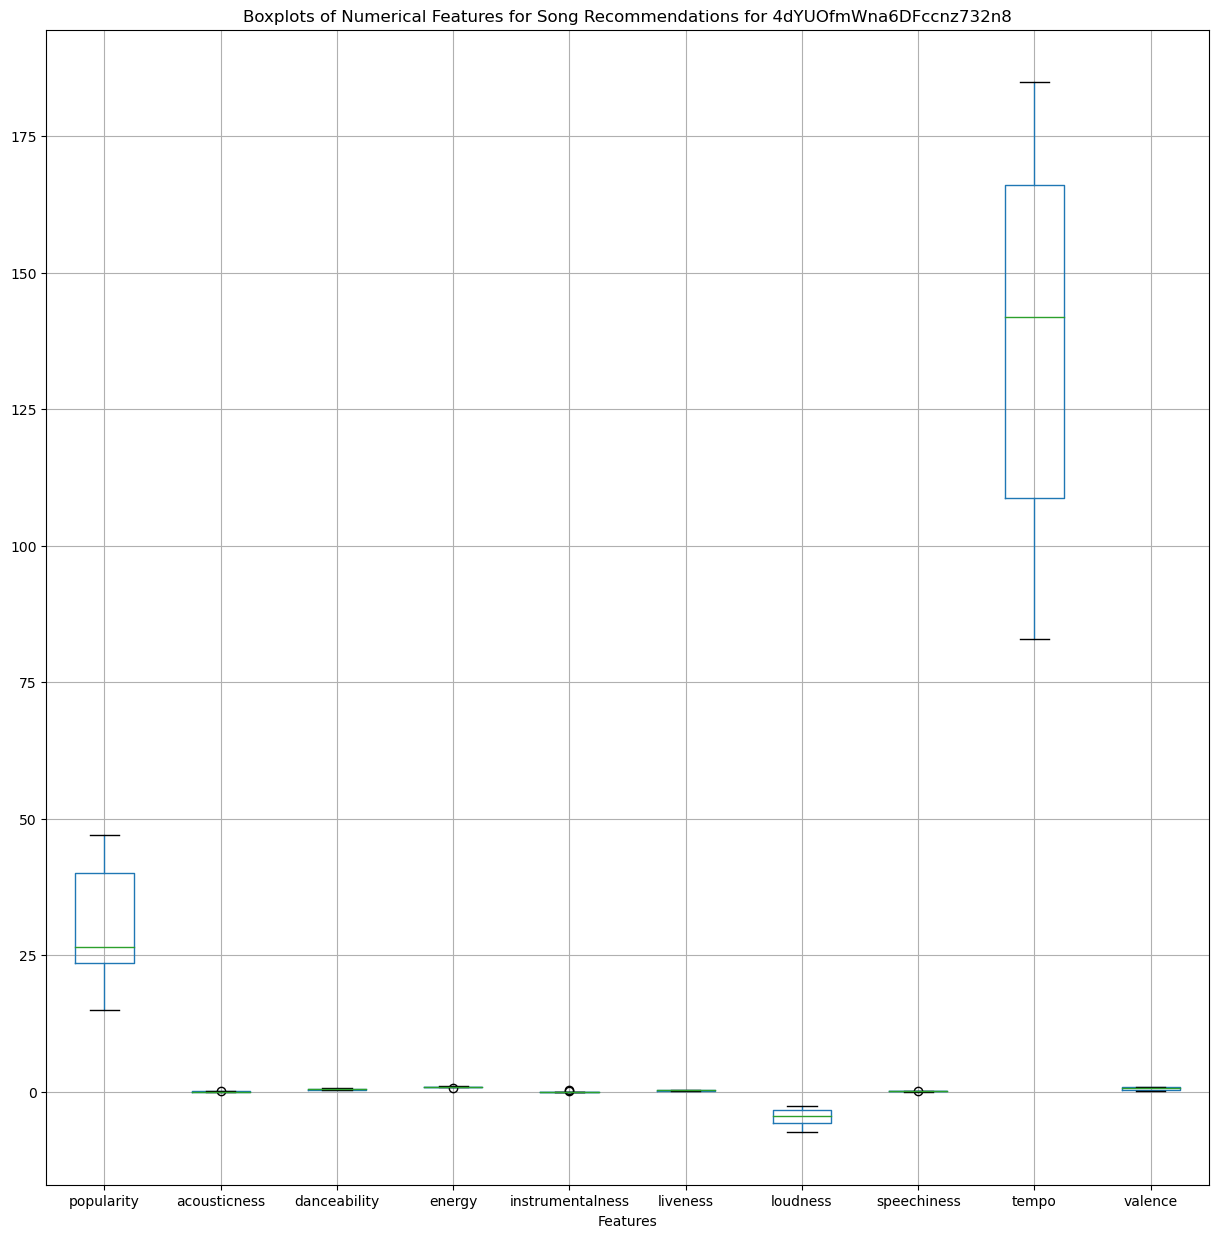

In [179]:
plt.figure(figsize=(15, 15))
stat_bplt_vec_0 = numeric_track_recommendations.boxplot(column=numeric_list)


stat_bplt_vec_0.plot()
plt.title(f"Boxplots of Numerical Features for Song Recommendations for {title_track}")
plt.xlabel("Features")


plt.show()

In [89]:
kaggle_df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,NaN,0,0.61,0.39,99373,0.91,0.00,C#,0.35,-1.83,Major,0.05,166.97,4-Apr,0.81
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),NaN,1,0.25,0.59,137373,0.74,0.00,F#,0.15,-5.56,Minor,0.09,174.00,4-Apr,0.82
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,NaN,3,0.95,0.66,170267,0.13,0.00,C,0.10,-13.88,Minor,0.04,99.49,4-May,0.37
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,NaN,0,0.70,0.24,152427,0.33,0.00,C#,0.10,-12.18,Major,0.04,171.76,4-Apr,0.23
4,Movie,Fabien Nataf,Ouverture,NaN,4,0.95,0.33,82625,0.23,0.12,F,0.20,-21.15,Major,0.05,140.58,4-Apr,0.39


In [90]:
kaggle_df.loc[kaggle_df.track_name.str.lower().str.contains("take on me")]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
3096,Alternative,Weezer,Take On Me,NaN,59,0.01,0.44,223560,0.76,0.00,G#,0.09,-3.86,Major,0.04,167.96,4-Apr,0.74
13631,Dance,a-ha,Take on Me,NaN,84,0.02,0.57,225280,0.90,0.00,F#,0.09,-7.64,Minor,0.05,84.41,4-Apr,0.88
17473,Dance,a-ha,Take On Me,NaN,0,0.01,0.53,228520,0.93,0.00,F#,0.05,-6.44,Minor,0.05,169.42,4-Apr,0.81
19917,Dance,a-ha,Take On Me - Kygo Remix,NaN,58,0.16,0.54,226667,0.78,0.00,A,0.14,-6.01,Major,0.11,179.96,4-Apr,0.62
77365,Children’s Music,Weezer,Take On Me,NaN,70,0.01,0.44,223560,0.76,0.00,G#,0.09,-3.86,Major,0.04,167.96,4-Apr,0.74
108853,Pop,a-ha,Take on Me,NaN,84,0.02,0.57,225280,0.90,0.00,F#,0.09,-7.64,Minor,0.05,84.41,4-Apr,0.88
110186,Pop,Weezer,Take On Me,NaN,70,0.01,0.44,223560,0.76,0.00,G#,0.09,-3.86,Major,0.04,167.96,4-Apr,0.74
151905,Pop,a-ha,Take On Me - MTV Unplugged,NaN,65,0.96,0.47,253907,0.20,0.00,A,0.68,-13.24,Major,0.04,127.36,4-Apr,0.31
155216,Rock,Reel Big Fish,Take On Me,NaN,60,0.02,0.58,199253,0.94,0.00,A,0.13,-3.00,Major,0.12,97.88,4-Apr,0.84
156518,Ska,Reel Big Fish,Take On Me,NaN,60,0.02,0.58,199253,0.94,0.00,A,0.13,-3.00,Major,0.12,97.88,4-Apr,0.84


## Generate Playlist

### Token Authorization/Blank Playlist

In [95]:
#  # THIS CODE WORKS -- However, I don't want to use a self-contained Flask app as it interrupts my flow
# app = Flask(__name__)

# sp_oauth = SpotifyOAuth(
#     client_id=CLIENT_ID,
#     client_secret=CLIENT_SECRET,
#     redirect_uri=REDIRECT_URI,
#     scope=SCOPE,
#     cache_path=".cache",
# )

# @app.route('/')
# def index():
#     return "Hello, this is a Flask app!"

# @app.route('/login')
# def login():
#     auth_url = sp_oauth.get_authorize_url()
#     return redirect(auth_url)

# @app.route('/callback')
# def callback():
#     code = request.args['code']
#     token_info = sp_oauth.get_access_token(code)
#     access_token = token_info['access_token']

#     sp = spotipy.Spotify(auth=access_token)

#     username = sp.me()['id']
#     playlist_name = 'My Blank Playlist'

#     playlist = sp.user_playlist_create(
#         user=username,
#         name=playlist_name,
#         public=False
#     )

#     return f"Playlist '{playlist_name}' created by user '{username}'"

# if __name__ == '__main__':
#     app.run(port=5000)

### Playlist Generation

In [136]:
# Initialize SpotifyOAuth
sp_oauth = SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=REDIRECT_URI,
    scope=SCOPE,
    cache_path=".cache",
    show_dialog=False,
)


def main(recommendations: List):
    # Get cached token or start authorization process
    access_token_info = sp_oauth.get_cached_token()
    if access_token_info:
        access_token = access_token_info["access_token"]
    else:
        print("Authorization required. Visit the following URL to authorize:")
        auth_url = sp_oauth.get_authorize_url()
        print(auth_url)
        return

    # Initialize spotipy with access token
    sp = spotipy.Spotify(auth=access_token)

    # Replace 'Your Username' with your Spotify username
    username = USERNAME
    for track_recommendation in recommendations:
        playlist_name = f"Recommendation Playlist for Track {track_recommendation[0]}"
        playlist_description = (
            f"These are the top 10 matches for track {track_recommendation[0]}"
        )

        try:
            # Create a blank playlist
            playlist = sp.user_playlist_create(
                user=username,
                name=playlist_name,
                description=playlist_description,
                public=False,
            )
            print(f"Playlist '{playlist_name}' was created")
        except spotipy.SpotifyException as e:
            print(f"An error occurred: {e}")

        # List of track IDs (URIs) to add to the playlist
        prefix = "spotify:track:"
        track_uris = list(prefix + x for x in track_recommendation)

        # track_ids = [
        #     'spotify:track:track_id_1',
        #     'spotify:track:track_id_2',
        #     # Add more track IDs here
        # ]

        # Add tracks to the playlist
        sp.user_playlist_add_tracks(
            user=username, playlist_id=playlist["id"], tracks=track_uris
        )


if __name__ == "__main__":
    main(recommendations)

Playlist 'Recommendation Playlist for Track 0Orkpepcdaq5GvnLh1Wb6p' was created
Playlist 'Recommendation Playlist for Track 3jOLdUMjt9nXjnLmbgnKBf' was created
Playlist 'Recommendation Playlist for Track 7sqdeBH06y0C3lHWVkK5HK' was created
Playlist 'Recommendation Playlist for Track 2QbR9yeeX7XHznRZwsyh3F' was created
Playlist 'Recommendation Playlist for Track 4dYUOfmWna6DFccnz732n8' was created
Playlist 'Recommendation Playlist for Track 3BUFs1YNRBoGgYNrK9hQov' was created
Playlist 'Recommendation Playlist for Track 1DSHVZBpsWVAmYOIXrTBVT' was created
Playlist 'Recommendation Playlist for Track 1IAMR2fZdD3ddqttxj9naT' was created
Playlist 'Recommendation Playlist for Track 7lb6AOilTFuvgokDoBEml7' was created
Playlist 'Recommendation Playlist for Track 3qjXFLKMp4zfMmugEGPaBx' was created
